<a href="https://colab.research.google.com/github/iroshm/Time-Series-Anomaly-Detection---google-colab/blob/master/Time_Series_Anomaly_Detection_At_Closing_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Wed Mar  4 03:55:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 3.9MB 37.9MB/s 
     |████████████████████████████████| 450kB 73.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22,18

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [0]:
!pip install kaggle

In [1]:

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:

df = pd.read_csv('/content/drive/My Drive/Data Sets/sandp500/individual_stocks_5yr/individual_stocks_5yr/AAL_data.csv')
df.head

<bound method NDFrame.head of             date   open   high    low  close    volume Name
0     2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1     2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2     2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3     2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4     2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
...          ...    ...    ...    ...    ...       ...  ...
1254  2018-02-01  54.00  54.64  53.59  53.88   3623078  AAL
1255  2018-02-02  53.49  53.99  52.03  52.10   5109361  AAL
1256  2018-02-05  51.99  52.39  49.75  49.76   6878284  AAL
1257  2018-02-06  49.32  51.50  48.79  51.18   6782480  AAL
1258  2018-02-07  50.91  51.98  50.89  51.40   4845831  AAL

[1259 rows x 7 columns]>

In [0]:

df = pd.read_csv('/content/drive/My Drive/Data Sets/sandp500/individual_stocks_5yr/individual_stocks_5yr/AAL_data.csv', parse_dates=['date'], index_col='date')


In [7]:
df.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [61]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

In [8]:
df.shape

(1259, 6)

In [12]:
ds = df[['close']] #select closing time
ds.head()

,close
date,
2013-02-08,14.75
2013-02-11,14.46
2013-02-12,14.27
2013-02-13,14.66
2013-02-14,13.99


In [13]:
ds.shape

(1259, 1)

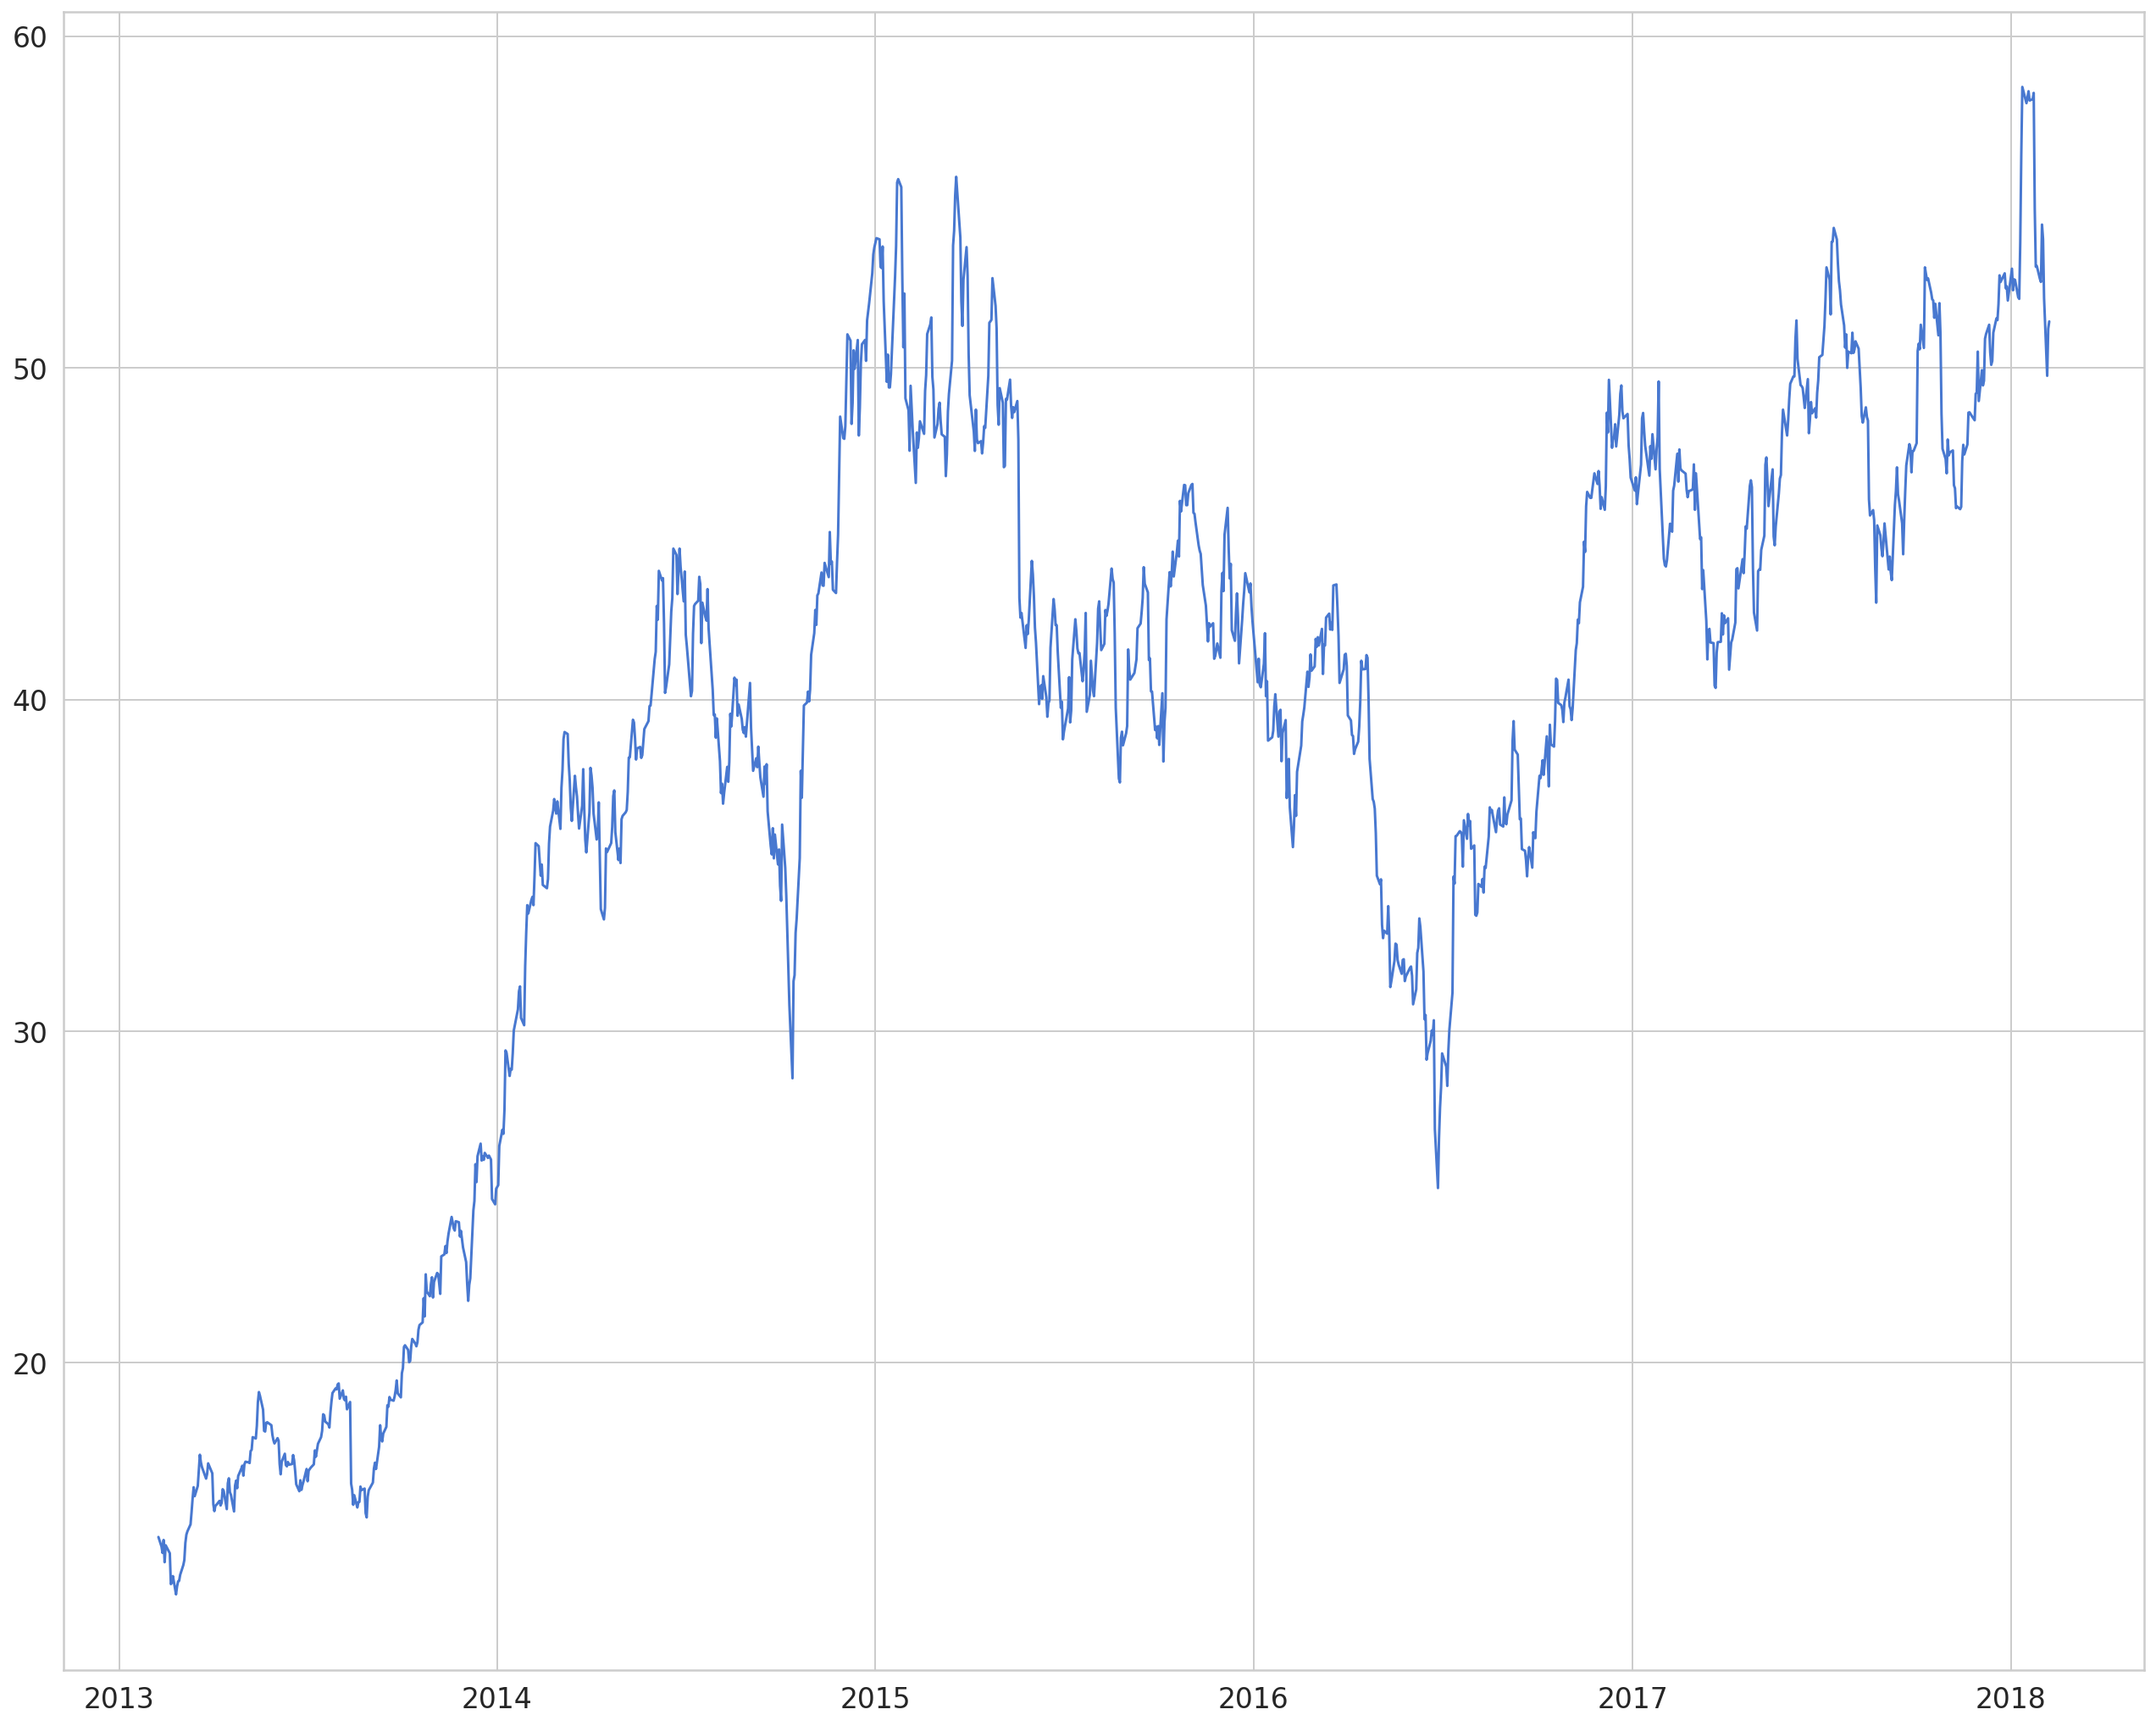

In [14]:
plt.plot(ds, label="close price")

In [0]:
#95% to train
train_size = int(len(ds)*0.95)
test_size = len(ds)-train_size

In [17]:
#take sub set from training set and test set
train, test = ds.iloc[0:train_size], ds.iloc[train_size:len(ds)]

print(train.shape, test.shape)

(1196, 1) (63, 1)


In [0]:
#scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

In [19]:
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
train.head()

,close
date,
2013-02-08,-2.129351
2013-02-11,-2.156254
2013-02-12,-2.173879
2013-02-13,-2.137700
2013-02-14,-2.199854


In [0]:
#create data set for LSTM model
#LSTM expects sequence of data 
#going to create number of sequences
#30 days as sequence for the closing price
# 1-30 jan 1886, 2-31 jan 1886 .....


In [0]:
#def create_dataset(x,y, time_step=1):
 # xs, ys = [], []
  #for i in range(len(x) - time_step):
   #   v = x.iloc[i:(i + time_step)].values #value of the current time step that we are interested
    #  xs.append(v)
      #take the jan 31 and try to predicts its value
      #this value is going to be our label
      #we are going to predict its value by previous 30 days
     # ys.append(y.iloc[i+time_step])
      #return as numpy arrays
      #return np.array(xs), np.array(ys)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
  


In [66]:
#convert train data set in to sequences

TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(
  train[['close']],
  train.close,
  TIME_STEPS
)

X_test, y_test = create_dataset(
  test[['close']],
  test.close,
  TIME_STEPS
)

print(X_train.shape)

(1166, 30, 1)


In [67]:
X_train.shape[1]


30

In [0]:
#1166 lines 1 col and time stamp is 30


In [0]:
# LSTM Autoencorder

#if the error is larger than some threshold 
#then we will say that current data point is a anomaly

model = keras.Sequential() 

# add a LSTM layer
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))

#DROP OUT LAYER for regularization
model.add(keras.layers.Dropout(rate=0.2))

#to just copy the values that we have already and return a sequence
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))#number of items in the first dimension

#reconstruct another LSTM layer to repeat n times
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

#output time distributed fully connected layer
#this layer provide us with the same amount of units that we have passed in as
#the input

#inputting a sequence of 30 closing prices and we are asking our model
#to predict the same sequence 
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)

model.compile(loss='mae', optimizer='adam')

In [70]:
#train is no different from a regular LSTM
history = model.fit(
    X_train,y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.1,
    shuffle = False
)

Train on 1049 samples, validate on 117 samples
Epoch 1/10
1049/1049 [==============================] - 8s 7ms/sample - loss: 0.4057 - val_loss: 0.4295
Epoch 2/10
1049/1049 [==============================] - 0s 211us/sample - loss: 0.2016 - val_loss: 0.1612
Epoch 3/10
1049/1049 [==============================] - 0s 225us/sample - loss: 0.1921 - val_loss: 0.1520
Epoch 4/10
1049/1049 [==============================] - 0s 208us/sample - loss: 0.1622 - val_loss: 0.1345
Epoch 5/10
1049/1049 [==============================] - 0s 218us/sample - loss: 0.1872 - val_loss: 0.2030
Epoch 6/10
1049/1049 [==============================] - 0s 217us/sample - loss: 0.1582 - val_loss: 0.1468
Epoch 7/10
1049/1049 [==============================] - 0s 222us/sample - loss: 0.1529 - val_loss: 0.1336
Epoch 8/10
1049/1049 [==============================] - 0s 227us/sample - loss: 0.1468 - val_loss: 0.1300
Epoch 9/10
1049/1049 [==============================] - 0s 205us/sample - loss: 0.1505 - val_loss: 0.1497
E

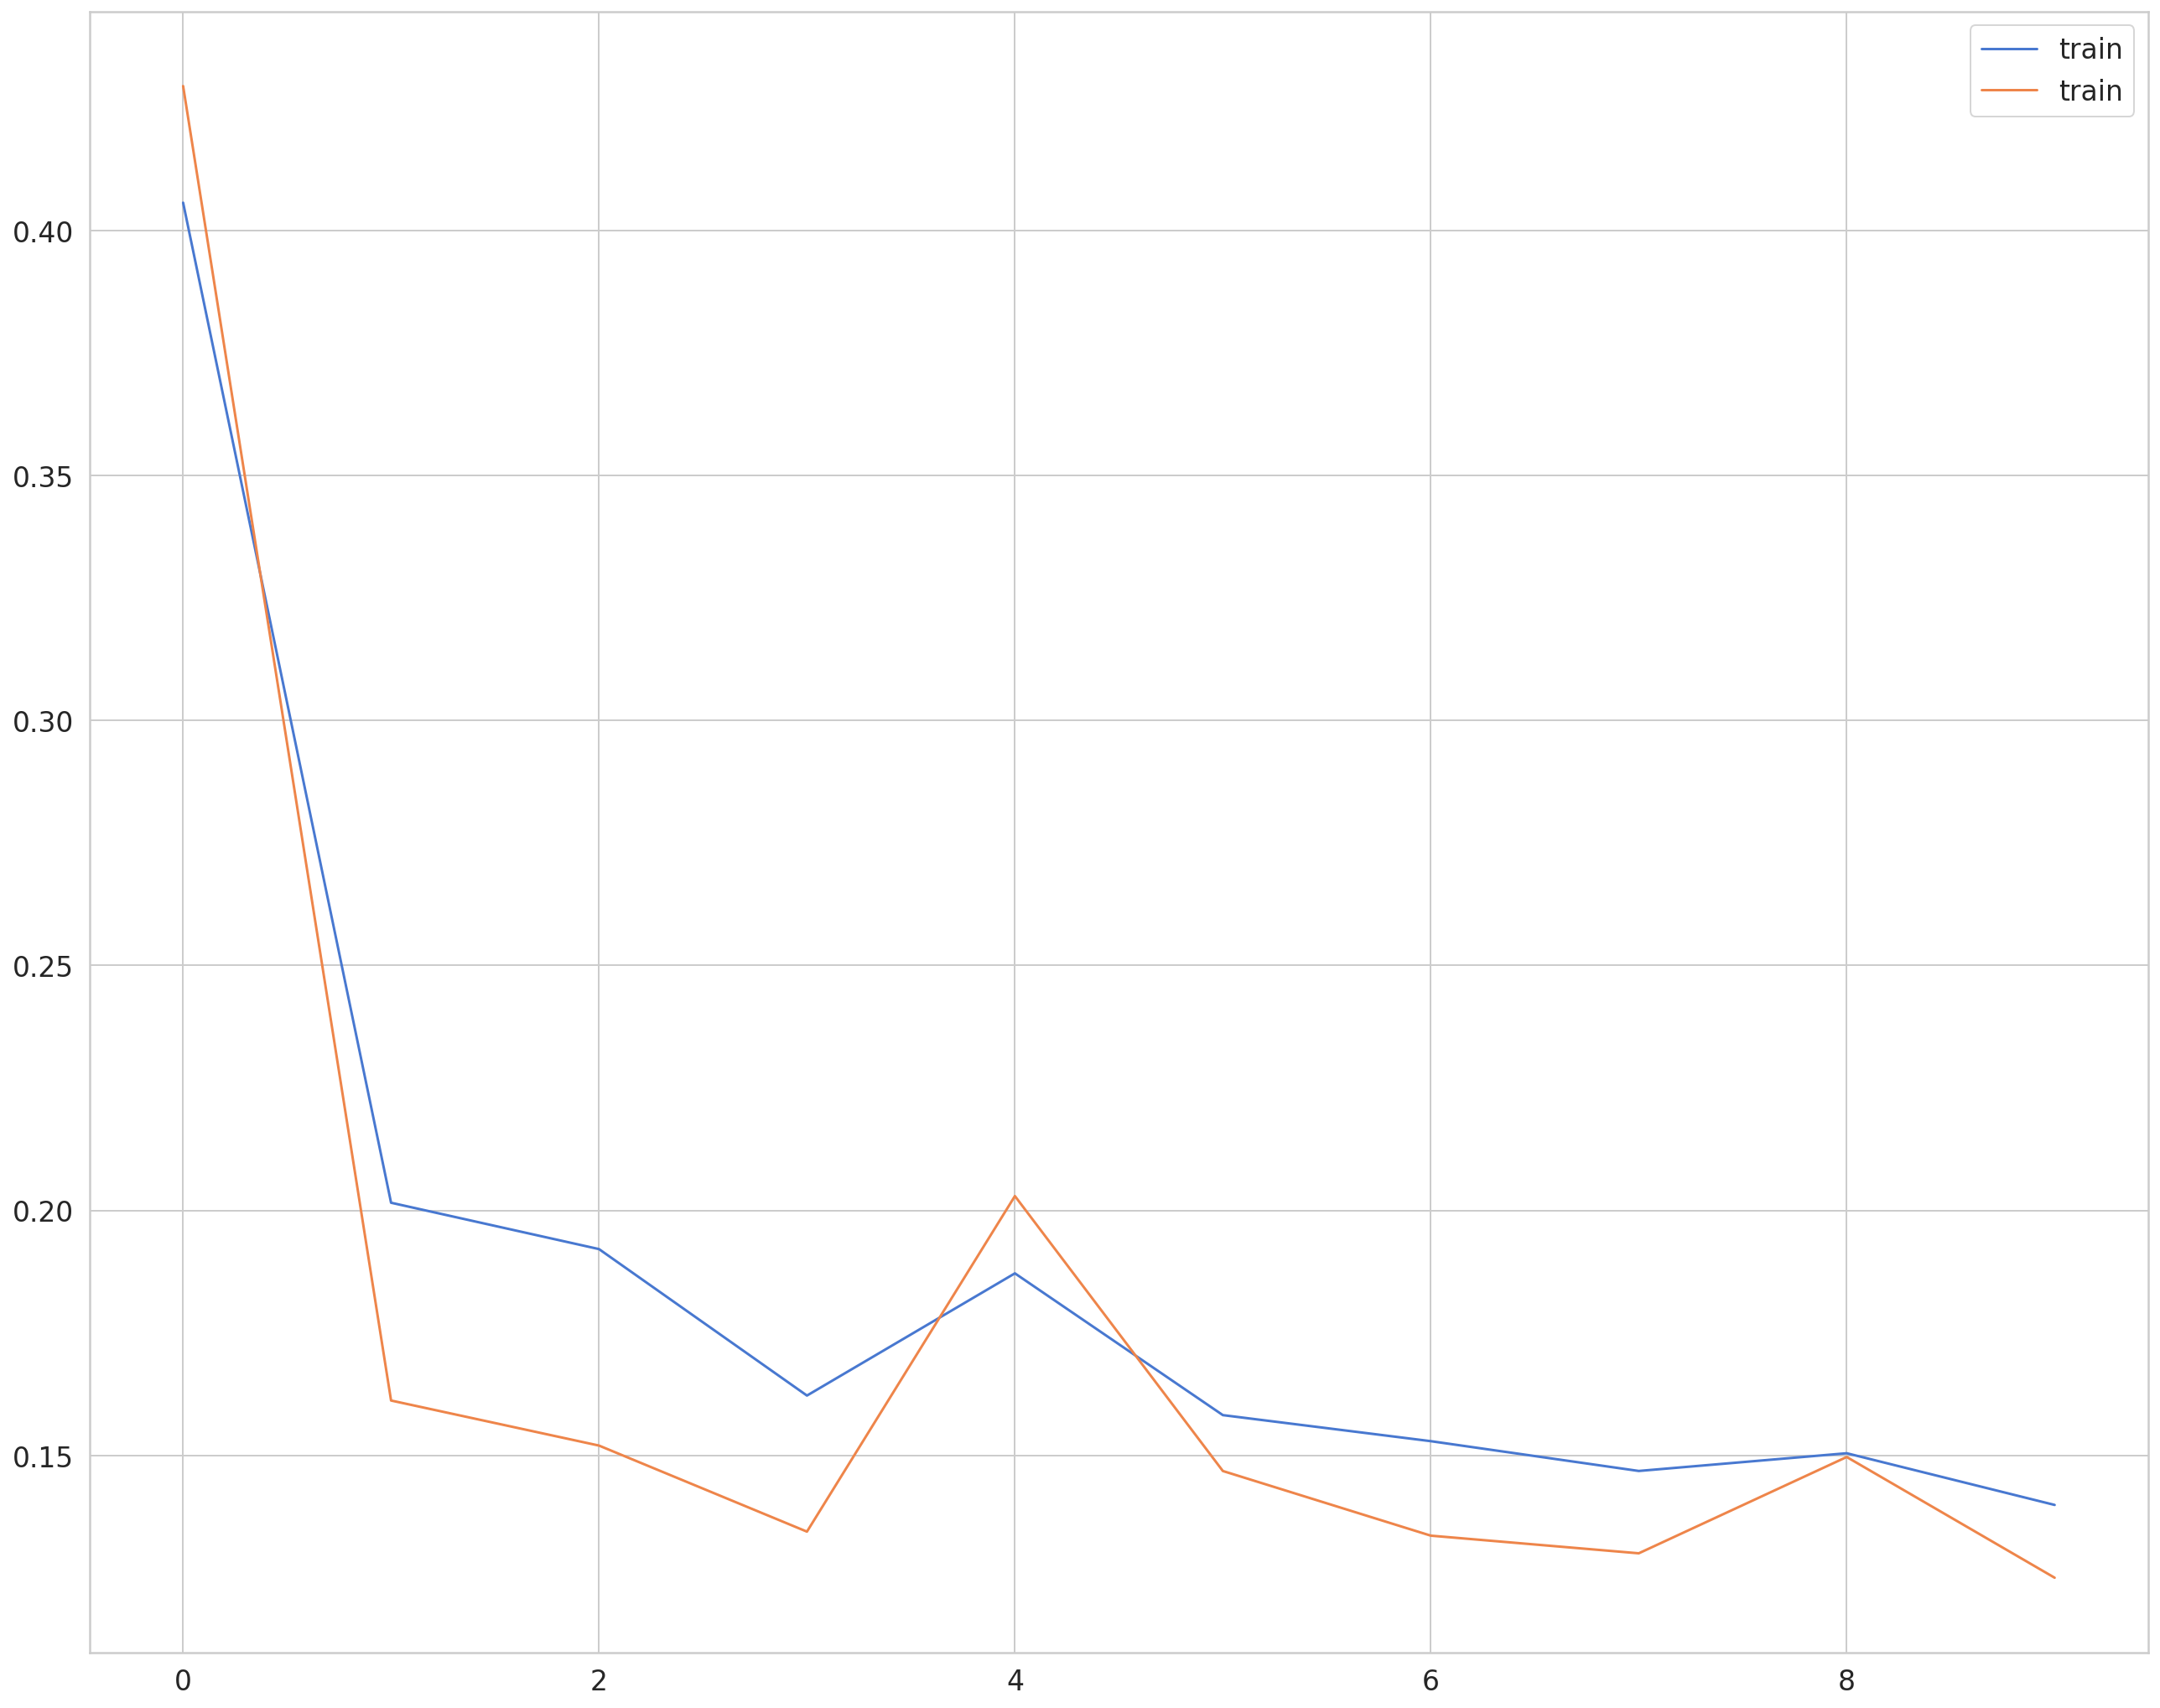

In [76]:
#Evaluation
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label ='train')
plt.legend();

In [0]:
X_train_pred = model.predict(X_train)

#mean absolute error
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

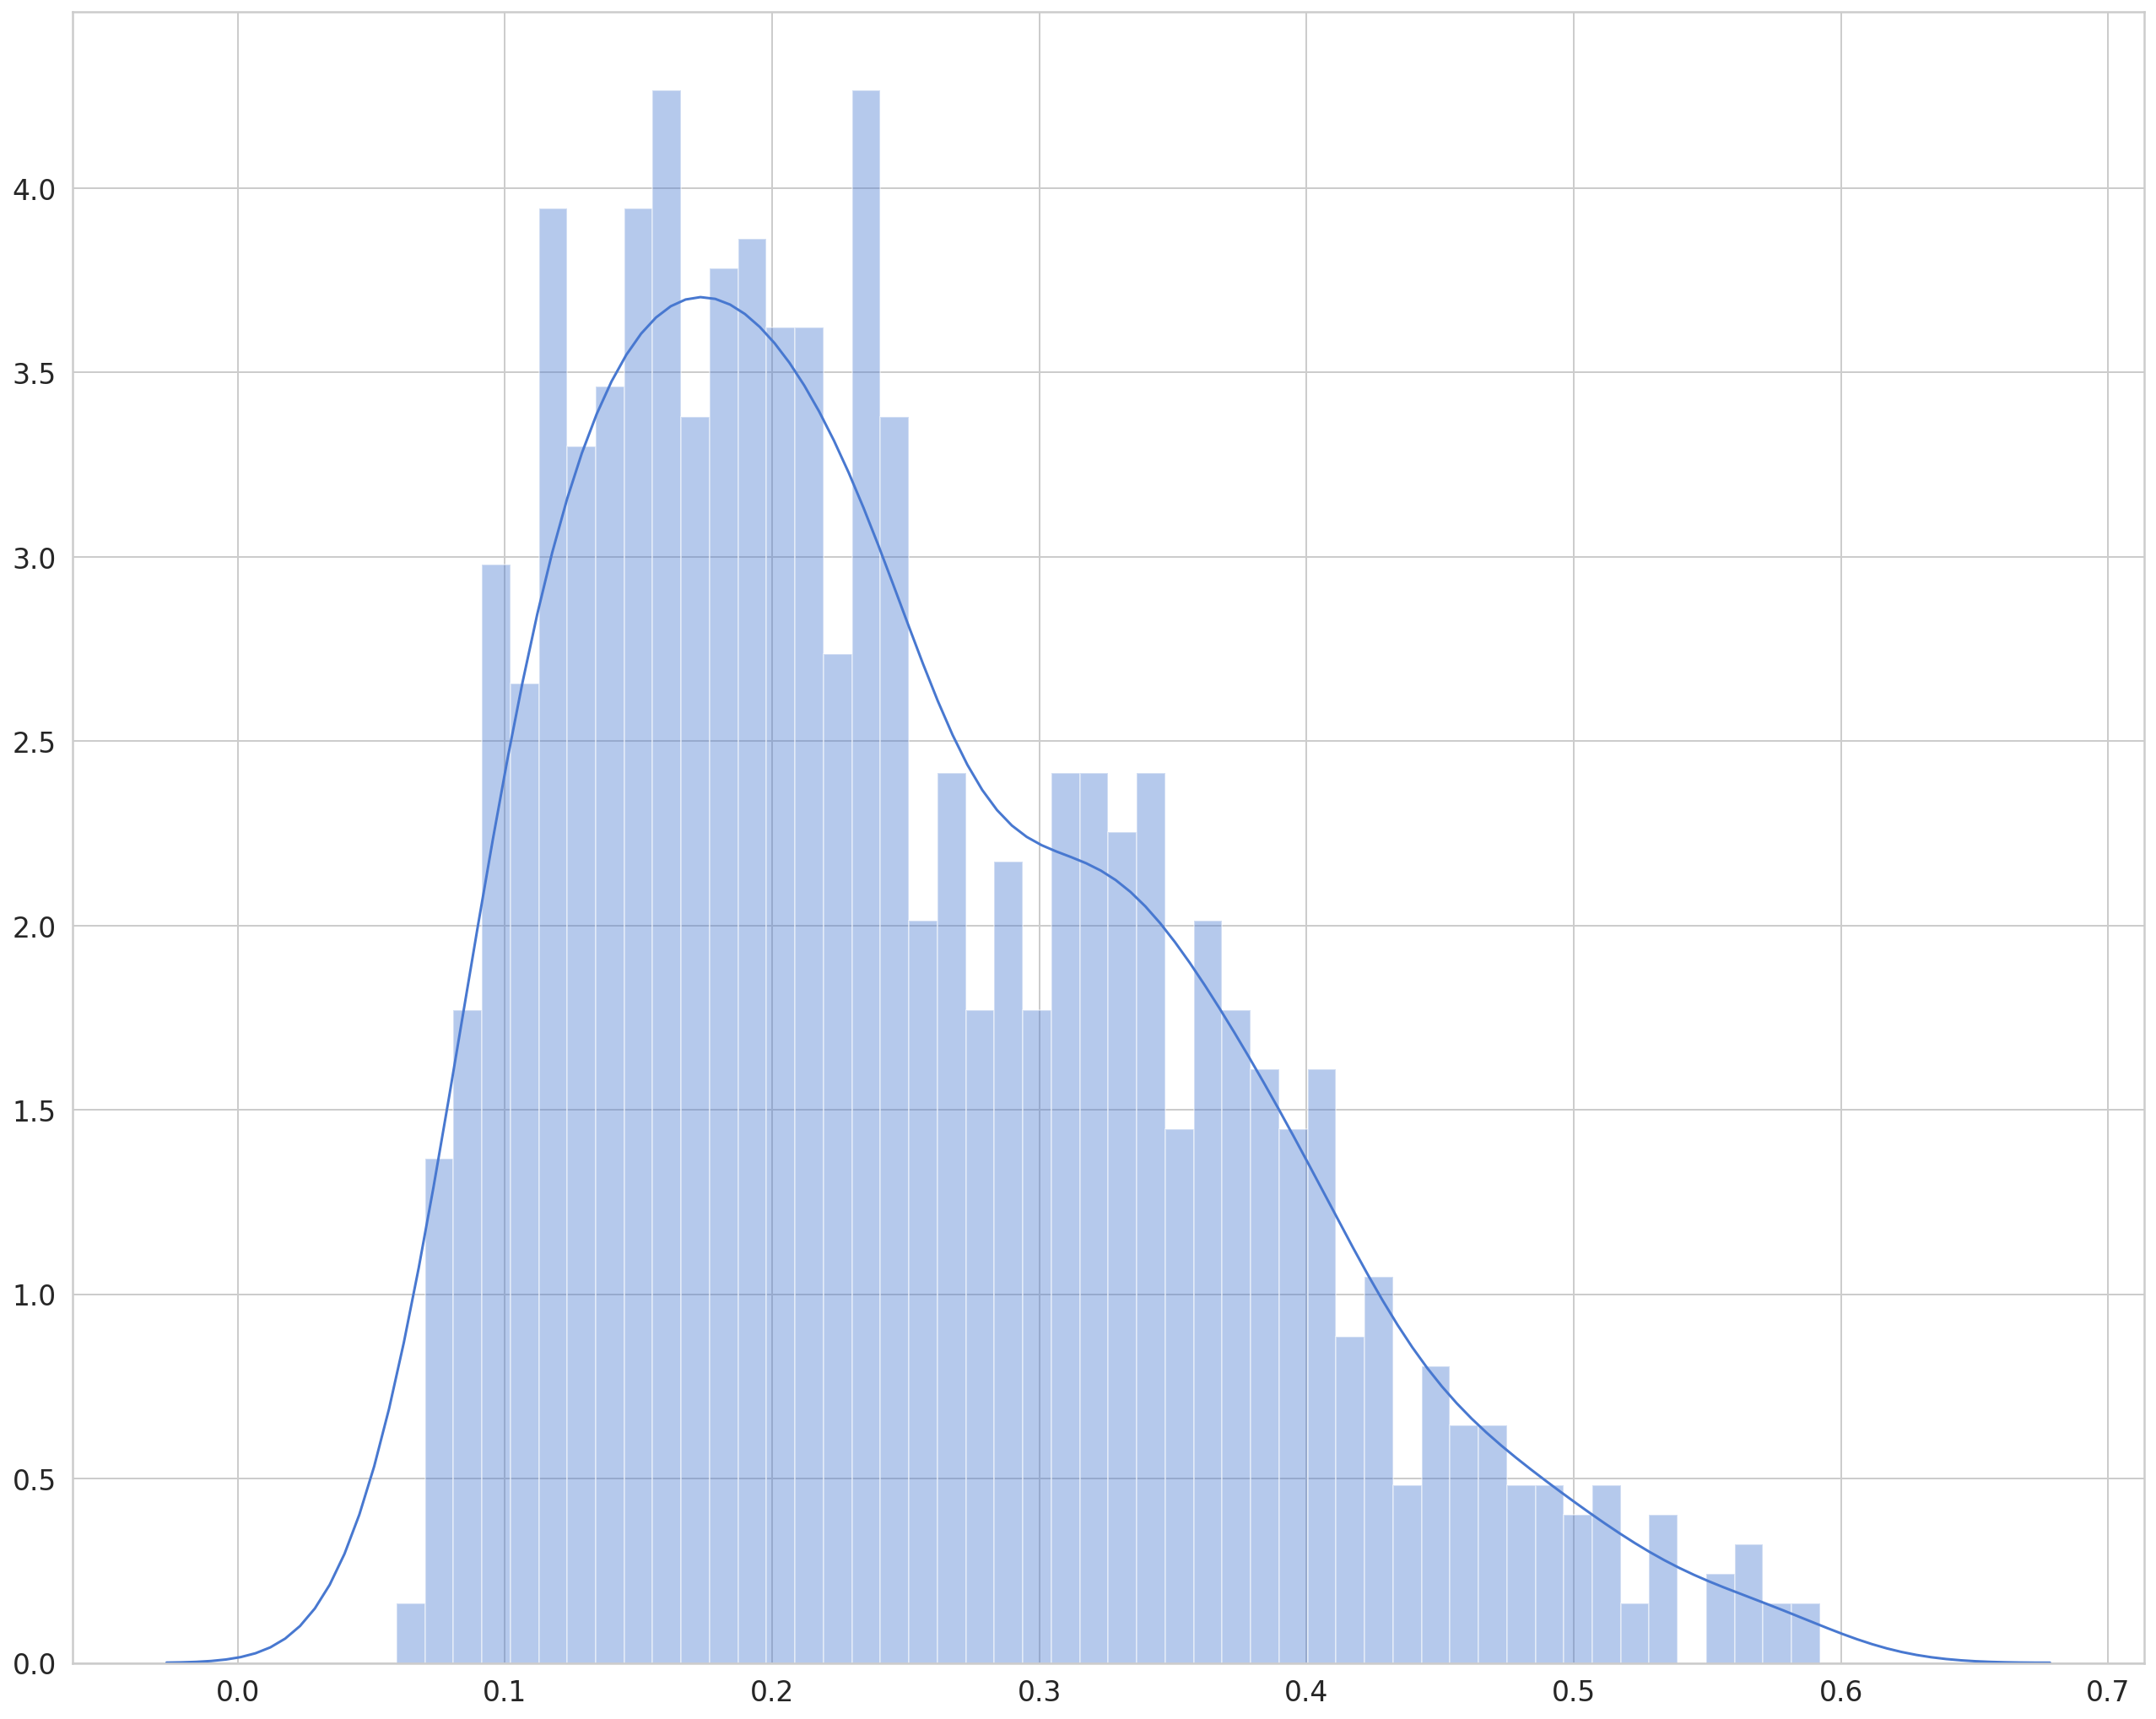

In [78]:
sns.distplot(train_mae_loss,bins=50, kde=True )

In [0]:
THRESHOLD = 0.3
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [0]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

In [92]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,loss,threshold,anomaly,close
date,,,,
2018-01-18,0.321170,0.3,True,1.914370
2018-01-19,0.327132,0.3,True,1.888395
2018-01-22,0.325177,0.3,True,1.892105
2018-01-23,0.321447,0.3,True,1.909731
2018-01-24,0.316555,0.3,True,1.585046
2018-02-06,0.373905,0.3,True,1.250157
2018-02-07,0.390180,0.3,True,1.270565


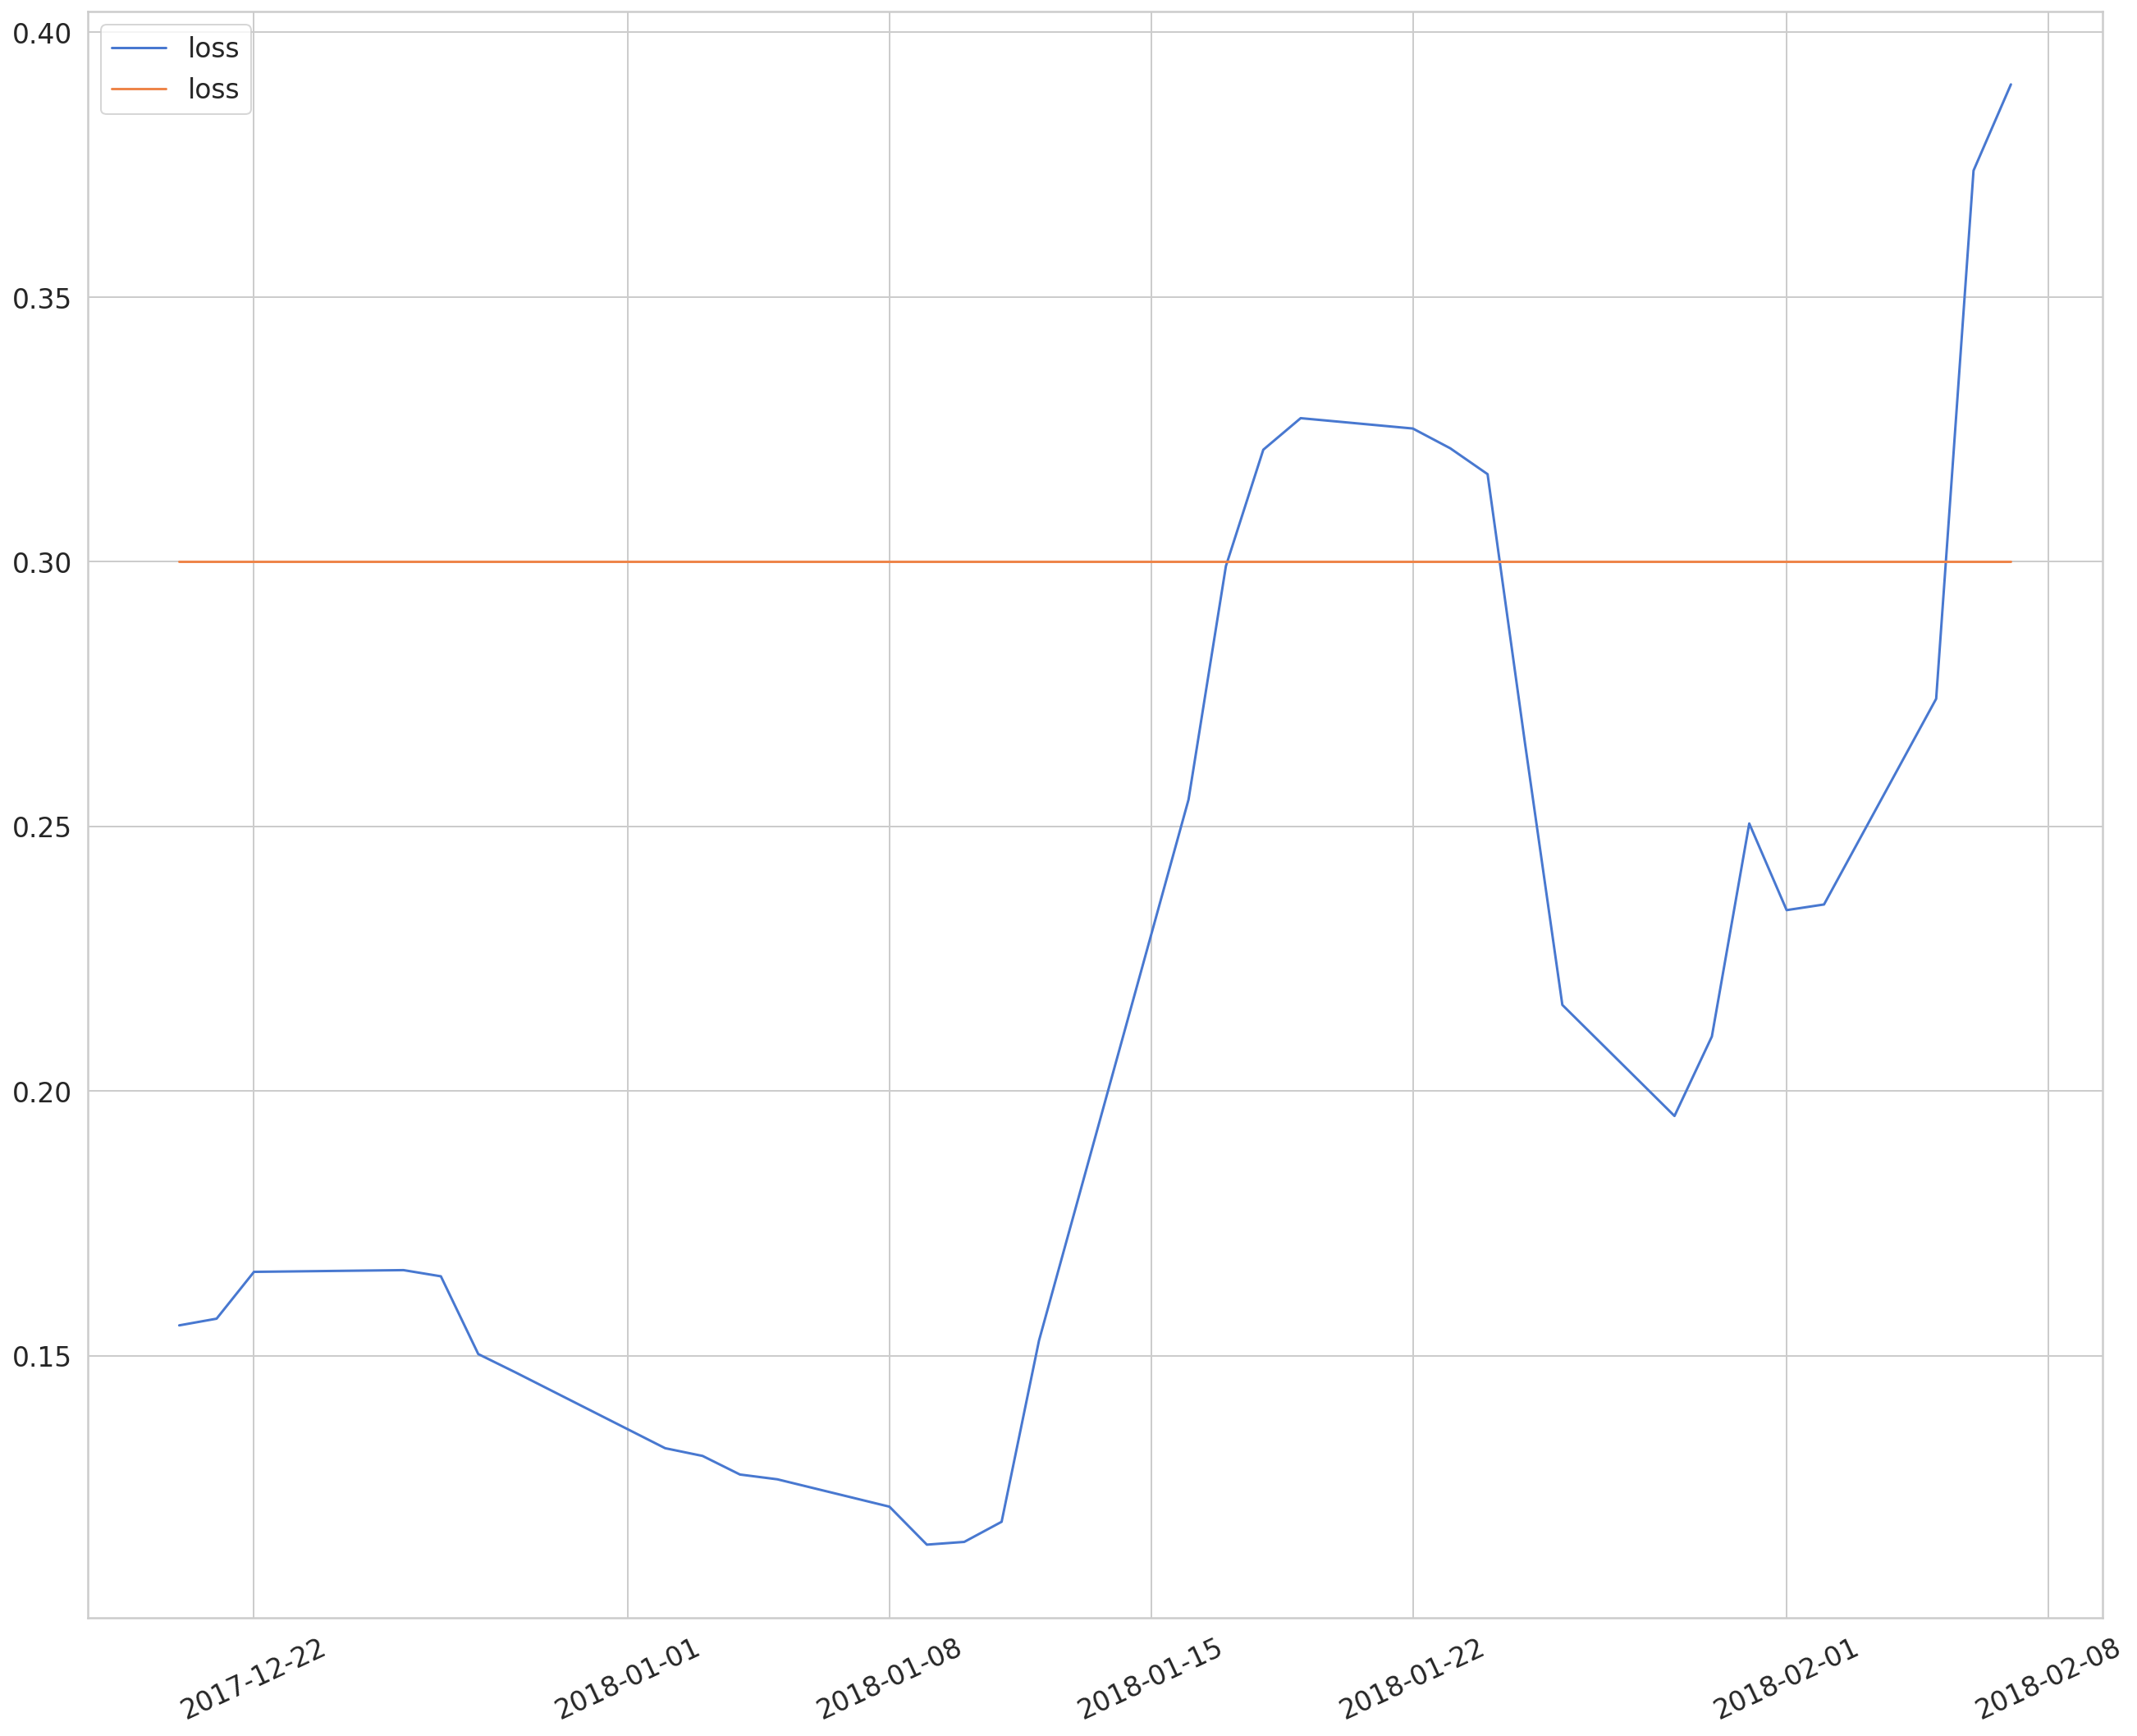

In [93]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='loss')
plt.xticks(rotation=25)
plt.legend();